Final File for USA models
- complete feature set / data set
- 5 models (XGBoost / SVM / Logistic Regression / LSTM / Random Forest)
- Every model is ran with Transaction Cost (Other file with TC)
- A rolling window is implemented, in contrary to a growing window
- Thresholding is applied to increase model performance

<h1>Data Loading & Preprocessing</h1>

In [1]:
# load the ES_part_x files up to number 11 into df_es
import numpy as np
import pandas as pd
df_es = pd.DataFrame()

for i in range(1, 12):
    file_name = f'NE_part_{i}.csv'
    try:
        df_part = pd.read_csv(file_name)
        df_es = pd.concat([df_es, df_part], ignore_index=True)
    except FileNotFoundError:
        print(f"File {file_name} not found. Skipping.")


# set Date column to datetime
df_es['Date'] = pd.to_datetime(df_es['Date'], errors='coerce')

# set Date as index and combine date with Time column so that it is a datetime index
df_es['DateTime'] = pd.to_datetime(df_es['Date'].astype(str) + ' ' + df_es['Time'], errors='coerce')
df_es.set_index('DateTime', inplace=True)
# drop the original Date and Time columns
df_es.drop(columns=['Date', 'Time'], inplace=True)
# sort the index
df_es.sort_index(inplace=True)


# Surprise Dataframe
# Load the Surprise dataset
df_surprise = pd.read_csv('JP_economic_releases_events.csv')

df_surprise.drop(columns=['S', 'Month', 'Surv(A)', 'Surv(H)', 'Surv(L)', 'Flag', 'Country/Region', 'Day', 'C', 'Category','Subcategory', 'Period', 'Actual'], inplace=True)
# Drop rows where surprise is NaN or -- (indicating no surprise)
df_surprise.dropna(subset=['Surprise'], inplace=True)
df_surprise = df_surprise[df_surprise['Surprise'] != '--']
# remove surprise values that are NaN or 0
df_surprise = df_surprise[df_surprise['Surprise'].notna() & (df_surprise['Surprise'] != 0)]
# Change surprise column to numeric, coercing errors
df_surprise['Surprise'] = pd.to_numeric(df_surprise['Surprise'], errors='coerce')

# Drop rows where Time is NaN
df_surprise.dropna(subset=['Time'], inplace=True)

# Convert Unnamed: 0 column to datetime
df_surprise['Unnamed: 0'] = pd.to_datetime(df_surprise['Unnamed: 0'], errors='coerce')
# Combine datetime column with Time column and set as index
df_surprise['DateTime'] = pd.to_datetime(df_surprise['Unnamed: 0'].astype(str) + ' ' + df_surprise['Time'], errors='coerce')
df_surprise.set_index('DateTime', inplace=True)
# Drop the original Unnamed: 0 and Time columns
df_surprise.drop(columns=['Unnamed: 0', 'Time'], inplace=True)
# Sort the index
df_surprise.sort_index(inplace=True)

# remove surprise values that are NaN or 0
df_surprise = df_surprise[df_surprise['Surprise'].notna() & (df_surprise['Surprise'] != 0)]

# Wincorsizing to get results between 0.5% and 99.5% percentile for Surprise values

lower_bound = df_surprise['Surprise'].quantile(0.005)
upper_bound = df_surprise['Surprise'].quantile(0.995)

df_surprise = df_surprise[(df_surprise['Surprise'] >= lower_bound) & (df_surprise['Surprise'] <= upper_bound)]


# Combining the 2 dataframes on the index
# outer join the two DataFrames on the index
df_combined = pd.merge(df_es, df_surprise, left_index=True, right_index=True, how='outer', suffixes=('_es', '_surprise'))

# remove all rows with NaN values in Open Close / Volume - Do not take out volume, can be 0 (not necessarily a mistake)
df_combined.dropna(subset=['Open', 'Close'], inplace=True)

# Adding a column called 'Volume_L1' which is the Volume shifted by 1 day - which is the volume of the previous minute matched up with the current minute
df_combined['Volume_L1'] = df_combined['Volume'].shift(1)

# Now we create the technical explanatory variables based on literature

def create_technical_features(df):
    """
    Creates all technical features for a dataframe containing price/volume data
    and three return columns (Return, Return_half, Return_double)
    """
    # 1. Original Features
    df_combined['Volume'] = df_combined['Volume']
    df_combined['Price'] = df_combined['Open']

    # 2. Simple Moving Averages (now includes all required windows)
    ma_windows = [5, 10, 15, 20, 50, 100, 200]  # Added missing windows for crossovers
    for window in ma_windows:
        df[f'SMA{window}'] = df['Close'].rolling(window).mean() 

    # 3. Moving Average Crossovers (now all SMAs exist)
    for window in [5, 10, 15, 20, 50, 100, 200]:
        # No more need for existence check since we created all SMAs
        df[f'SMA{window}Cross'] = (df['Close'] > df[f'SMA{window}']).astype(int) # 1 for above SMA, 0 for below

    # 4. Consecutive Price Trends
    trend_periods = [10, 15, 50]
    for period in trend_periods:
        df[f'UpDown{period}'] = np.sign(df['Close'].pct_change(period)) # 1 for up, -1 for down, NaN for no change

    # Ensure we keep the original return columns
    return_cols = ['Return', 'Return_half', 'Return_double']
    for col in return_cols:
        if col in df.columns:
            df[col] = df[col]  # Maintain existing returns

    return df

# Example usage:
# df_combined must contain: 'volume', 'close' columns plus the 3 return columns
df_combined = create_technical_features(df_combined)

import datetime
import pandas as pd
import pandas_datareader as pdr

# --- 1. Set Start and End Dates, matches up with last date of df_combined ---
start = df_combined.index.min() # Get the first date from df_combined
end = df_combined.index.max()  # Get the last date from df_combined

# print start and end
print(f"Start Date: {start}, End Date: {end}")

# --- 2. Get GDP Growth Data ---
gdp_gr = pdr.DataReader('A191RL1Q225SBEA', 'fred', start, end)

# Create gdp_gr_ml dataframe
gdp_gr_ml = gdp_gr.reset_index()
gdp_gr_ml.rename(columns={'A191RL1Q225SBEA': 'gdp_gr'}, inplace=True)
gdp_gr_ml['DateTime'] = pd.to_datetime(gdp_gr_ml['DATE']) + pd.Timedelta(hours=23, minutes=59)
gdp_gr_ml = gdp_gr_ml[['DateTime', 'gdp_gr']]

# for both datasets set 'DateTime' as index and then drop columns
gdp_gr_ml.set_index('DateTime', inplace=True)

# make sure sorted on datetime
gdp_gr_ml.sort_index(inplace=True)


# Combine with Final Dataframe

# Merge the last known GDP growth merge on index
df_combined = pd.merge_asof(
    df_combined,
    gdp_gr_ml,
    on='DateTime',
    direction='backward'
)

# Rename the merged columns to last_gdp_gr and last_vix
df_combined = df_combined.rename(columns={
    'gdp_gr': 'last_gdp_gr'
})

# Set DateTime column as Index
df_combined.set_index('DateTime', inplace=True)

def calculate_daily_realized_volatility(df, freq='5min', close_col='Close'):
    """
    Calculates the daily realized volatility (non-annualized) from intraday data.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index and a close price column.
        freq (str): The sampling frequency (e.g., '1min', '5min', '15min').
        close_col (str): The name of the close price column.

    Returns:
        pd.Series: A Series of daily (non-annualized) realized volatility.
    """
    # Ensure the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("The DataFrame index must be a DatetimeIndex.")
        
    # Resample the close price to the desired frequency
    df_resampled = df[close_col].resample(freq).last()

    # Calculate log returns
    log_returns = np.log(df_resampled).diff().dropna()

    # Group by day and calculate the sum of squared returns (realized variance)
    realized_variance_daily = (log_returns**2).resample('D').sum()
    
    # Filter out days with no trading activity
    realized_variance_daily = realized_variance_daily[realized_variance_daily > 0]
    
    # Calculate daily volatility (standard deviation), which is the square root of variance.
    # The result is NOT annualized, making it suitable for ML models.
    realized_volatility_daily = np.sqrt(realized_variance_daily)
    
    return realized_volatility_daily.dropna()


def analyze_and_add_volatility(df_combined):
    """
    Calculates daily realized volatility and adds it as a new column
    to the provided DataFrame in-place.

    Args:
        df_combined (pd.DataFrame): Your DataFrame with minute-level data.
                                    It must have a DatetimeIndex and a 'Close' column.
                                    This function modifies the DataFrame in-place.
    
    Returns:
        pd.DataFrame: The modified DataFrame with the new 'daily realized volatility' column.
    """
    # --- 1. Calculate Volatility ---
    # We use a 5-minute interval as a standard practice to balance capturing
    # volatility information and reducing market microstructure noise.
    # You can change this value if needed.
    sampling_interval = '5min'
    print(f"Calculating daily realized volatility using a '{sampling_interval}' sampling interval...")
    
    daily_volatility = calculate_daily_realized_volatility(
        df_combined, 
        freq=sampling_interval, 
        close_col='Close' # Using 'Close' with a capital C
    )

    # --- 2. Add Volatility Column to DataFrame ---
    # Map the calculated daily volatility back to the original minute-level DataFrame.
    # Each row will have the realized volatility value for its corresponding day.
    print("Adding 'daily realized volatility' column to the DataFrame...")
    # Normalize index to match the daily frequency of the volatility series
    df_combined['daily realized volatility'] = df_combined.index.normalize().map(daily_volatility)
    
    print("\n'daily realized volatility' column has been added successfully.")
        
    return df_combined


# --- HOW TO USE ---
if __name__ == '__main__':
    # 1. Make sure your DataFrame `df_combined` is loaded and available.
    #    It must have a DatetimeIndex and columns named:
    #    'open', 'high', 'low', 'Close', 'tick_count', 'volume'.
    #
    # Example of loading your data:
    # df_combined = pd.read_csv('path/to/your/futures_data.csv', 
    #                           parse_dates=['timestamp_column'], 
    #                           index_col='timestamp_column')

    # 2. Once `df_combined` is loaded, uncomment and run the following line:
    # df_combined_with_vol = analyze_and_add_volatility(df_combined)
    
    print("Script is ready. Please load your 'df_combined' DataFrame and call 'analyze_and_add_volatility(df_combined)' to start.")
    
    # For demonstration, if a variable named `df_combined` exists, we'll run the analysis.
    if 'df_combined' in locals() or 'df_combined' in globals():
        print("\n'df_combined' detected. Running analysis...")
        df_combined_with_vol = analyze_and_add_volatility(df_combined)

Start Date: 2008-02-01 09:01:00, End Date: 2024-12-19 15:46:00
Script is ready. Please load your 'df_combined' DataFrame and call 'analyze_and_add_volatility(df_combined)' to start.

'df_combined' detected. Running analysis...
Calculating daily realized volatility using a '5min' sampling interval...
Adding 'daily realized volatility' column to the DataFrame...

'daily realized volatility' column has been added successfully.


In [2]:
df_combined

,Open,High,Low,Close,Volume,Tick Count,Event,Ticker,Prior,Revised,...,SMA15Cross,SMA20Cross,SMA50Cross,SMA100Cross,SMA200Cross,UpDown10,UpDown15,UpDown50,last_gdp_gr,daily realized volatility
DateTime,,,,,,,,,,,,,,,,,,,,,
2008-02-01 09:01:00,10297.0,10320.0,10290.0,10320.0,4899.0,209.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0.014026
2008-02-01 09:02:00,10313.0,10320.0,10297.0,10313.0,1070.0,130.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0.014026
2008-02-01 09:03:00,10305.0,10320.0,10305.0,10313.0,857.0,78.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0.014026
2008-02-01 09:04:00,10320.0,10328.0,10313.0,10328.0,1376.0,83.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0.014026
2008-02-01 09:05:00,10336.0,10358.0,10328.0,10351.0,2403.0,197.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0.014026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19 15:42:00,38990.0,38990.0,38990.0,38990.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1.0,1.0,1.0,2.4,0.015375
2024-12-19 15:43:00,38990.0,38990.0,38990.0,38990.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1.0,1.0,1.0,2.4,0.015375
2024-12-19 15:44:00,38990.0,38990.0,38990.0,38990.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1.0,1.0,1.0,2.4,0.015375


Creating Target column and Forward Return column for performance calculation

TC is included in the target / forward return column calculation

In [3]:
import pandas as pd
import numpy as np

# --- Assumed DataFrame ---
# This code assumes you have a pre-existing DataFrame named 'df_combined'
# with a 'Close' price column.

# --- Configuration ---
# Base holding period. For data in minutes, this represents 20 minutes.
holding_period = 20

# Define the horizons for calculation.
horizons = ['', '_half', '_double']

# --- Main Loop to Generate Columns ---
for h in horizons:
    # 1. Determine the calculation period and descriptive minute value
    if h == '_half':
        period = holding_period // 2
        minutes = holding_period // 2
    elif h == '_double':
        period = holding_period * 2
        minutes = holding_period * 2
    else:  # h == ''
        period = holding_period
        minutes = holding_period

    # 2. Define the new, descriptive column names
    return_col_name = f'Forward Return ({minutes} min)'
    target_col_name = f'Target Signal ({minutes} min)'

    # 3. Calculate the base forward return using the 'Close' price.
    # This shifts the future 'Close' price to the current row to represent
    # the potential return from a trade initiated now.
    future_price = df_combined['Close'].shift(-period)
    current_price = df_combined['Close']

    # Calculate return for a long position (buy low, sell high)
    long_return = (future_price / current_price) - 1

    # Calculate return for a short position (sell high, buy low)
    short_return = (current_price / future_price) - 1

    # 4. Create the Forward Return column.
    # This represents the gross percentage return for a long position.
    df_combined[return_col_name] = long_return

    # 5. Create the categorical "Target Signal" column.
    # The target is based on whether a trade is profitable, ignoring costs.
    # 0 = Hold, 1 = Buy, 2 = Sell

    # "Buy" signal is generated if the long return is positive.
    cond_buy = long_return > 0

    # "Sell" signal is generated if the short return is positive.
    cond_sell = short_return > 0

    # Apply the signals to the target column
    df_combined[target_col_name] = 0  # Default to Hold
    df_combined.loc[cond_buy, target_col_name] = 1
    df_combined.loc[cond_sell, target_col_name] = 2

# The 'df_combined' DataFrame is now updated with the six new columns,
# calculated without considering transaction costs.

Create feature column for each Ticker

In [4]:
import pandas as pd
import numpy as np

# This script assumes 'df_combined' is an existing DataFrame with a DateTimeIndex
# and columns 'Ticker' and 'Surprise'.

# --- 1. Filter for Event Rows Only ---
# First, create a smaller dataframe that only contains rows where a surprise occurred.
# This makes the pivot operation much more efficient.
print("Step 1: Filtering for rows with surprise events...")
surprise_events_only = df_combined[df_combined['Surprise'].notna()].copy()
print(f"Found {len(surprise_events_only)} rows with surprise events to pivot.")


# --- 2. Pivot the Filtered Data ---
# Now, we pivot this smaller dataframe.
# - The index of the new dataframe will be the original DateTimeIndex.
# - New columns will be created from the unique values in the 'Ticker' column.
# - The values for these new columns will be taken from the 'Surprise' column.
# - `fill_value=0` is critical: it ensures that for any given event row, all ticker
#   columns that were NOT part of that event are filled with 0.
print("\nStep 2: Pivoting the data...")
event_df = surprise_events_only.pivot_table(
    index=surprise_events_only.index,
    columns='Ticker',
    values='Surprise',
    fill_value=0
)

# Optional: Add a suffix to the new column names for clarity
event_df = event_df.add_suffix('_Surprise')
print("Pivoting complete.")


# --- 3. Verify the Result ---
print("\n--- Event DataFrame Sample ---")
print(event_df.head())

print(f"\nShape of the new event DataFrame: {event_df.shape}")
print(f"Number of rows matches the number of events, and number of columns matches unique tickers.")

# The `event_df` is now ready. It only contains rows from event times,
# and each ticker has its own column filled with either the surprise value or 0.


Step 1: Filtering for rows with surprise events...
Found 3932 rows with surprise events to pivot.

Step 2: Pivoting the data...
Pivoting complete.

--- Event DataFrame Sample ---
Ticker               BOJDPBAL Index_Surprise  BOJDTR Index_Surprise  \
DateTime                                                              
2008-02-08 14:00:00                      0.0                    0.0   
2008-02-26 14:00:00                      0.0                    0.0   
2008-02-29 14:00:00                      0.0                    0.0   
2008-03-03 10:30:00                      0.0                    0.0   
2008-03-12 14:00:00                      0.0                    0.0   

Ticker               BOJTARMB Index_Surprise  JBSIBCLA Index_Surprise  \
DateTime                                                                
2008-02-08 14:00:00                      0.0                      0.0   
2008-02-26 14:00:00                      0.0                      0.0   
2008-02-29 14:00:00            

In [5]:
# Step 2: Selecting feature and target columns from df_combined
# all columns with 'SMA' at start or 'UpDown' and 'Last_GDP_GR' and 'Last_VIX' at the end and
feature_columns = [col for col in df_combined.columns if col.startswith('SMA') or col.startswith('UpDown') or col in ['last_gdp_gr', 'daily realized volatility']]
columns_to_join = feature_columns

# also include the 'R' and 'Volume_L1' and 'Surprise' columns
columns_to_join += ['R', 'Volume_L1', 'Surprise', 'Std Dev']

# also include the return columns
list = [
    'Forward Return (20 min)',
    'Target Signal (20 min)',
    'Forward Return (10 min)',
    'Target Signal (10 min)',
    'Forward Return (40 min)',
    'Target Signal (40 min)'
]

columns_to_join += list

features_and_target_from_combined = df_combined[columns_to_join]

ml_df = event_df.join(features_and_target_from_combined, how='inner')

# Clean up any potential NaNs that might arise from the join, just in case.
ml_df.fillna(0, inplace=True)

print("Join complete.")


# --- 4. Verify the Final DataFrame ---
print("\n--- Final ML-Ready DataFrame ---")
print(ml_df.head())

print(f"\nShape of the final DataFrame: {ml_df.shape}")
print(f"The number of rows ({ml_df.shape[0]}) should match the number of surprise events.")
print("\nFinal columns available for the model:")
print(ml_df.columns.tolist())

# The `ml_df` DataFrame is now complete and ready to be split into X (all columns except Target)
# and y (the Target column) to be fed into your XGBoost model.

Join complete.

--- Final ML-Ready DataFrame ---
                     BOJDPBAL Index_Surprise  BOJDTR Index_Surprise  \
DateTime                                                              
2008-02-08 14:00:00                      0.0                    0.0   
2008-02-08 14:00:00                      0.0                    0.0   
2008-02-26 14:00:00                      0.0                    0.0   
2008-02-29 14:00:00                      0.0                    0.0   
2008-02-29 14:00:00                      0.0                    0.0   

                     BOJTARMB Index_Surprise  JBSIBCLA Index_Surprise  \
DateTime                                                                
2008-02-08 14:00:00                      0.0                      0.0   
2008-02-08 14:00:00                      0.0                      0.0   
2008-02-26 14:00:00                      0.0                      0.0   
2008-02-29 14:00:00                      0.0                      0.0   
2008-02-29 14:0

In [6]:
# rename ml_df to df_ml
df_ml = ml_df

# adjust df_ml so that index, DateTime, become a single column
df_ml.reset_index(inplace=True)

df_ml

,DateTime,BOJDPBAL Index_Surprise,BOJDTR Index_Surprise,BOJTARMB Index_Surprise,JBSIBCLA Index_Surprise,JBSIBCLM Index_Surprise,JCOMACF Index_Surprise,JCOMHCF Index_Surprise,JCOMSHCF Index_Surprise,JCPNEFFE Index_Surprise,...,R,Volume_L1,Surprise,Std Dev,Forward Return (20 min),Target Signal (20 min),Forward Return (10 min),Target Signal (10 min),Forward Return (40 min),Target Signal (40 min)
0,2008-02-08 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,67.0,-5.48,0.68,0.000000,0,-0.001506,2,0.000000,0
1,2008-02-08 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,32.0,-0.67,0.45,-0.000803,2,-0.002309,2,-0.001506,2
2,2008-02-26 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,472.0,3.18,0.41,-0.002828,2,-0.003582,2,-0.002828,2
3,2008-02-29 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62.3656,314.0,2.25,2.93,-0.000770,2,-0.001444,2,-0.003658,2
4,2008-02-29 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.1613,164.0,1.76,0.04,-0.000770,2,-0.001444,2,-0.002984,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,2024-07-01 08:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,83.8710,82.0,-1.05,2.62,-0.001236,2,-0.001740,2,-0.000731,2
3928,2024-07-01 08:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.5806,82.0,-0.22,2.24,-0.000731,2,-0.001740,2,-0.000731,2
3929,2024-07-01 08:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.5054,82.0,-0.41,2.41,-0.000479,2,-0.001992,2,-0.000252,2
3930,2024-07-05 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60.2151,50.0,0.33,0.46,-0.000246,2,0.000000,0,-0.000715,2


In [7]:
transaction_cost = 0.00000

<h1>XGBoost model</h1>
- Without transaction cost
- Rolling window

Feature Columns: ['BOJDPBAL Index_Surprise', 'BOJDTR Index_Surprise', 'BOJTARMB Index_Surprise', 'JBSIBCLA Index_Surprise', 'JBSIBCLM Index_Surprise', 'JCOMACF Index_Surprise', 'JCOMHCF Index_Surprise', 'JCOMSHCF Index_Surprise', 'JCPNEFFE Index_Surprise', 'JFYFCPI2 Index_Surprise', 'JFYFCPIC Index_Surprise', 'JGDFDEFY Index_Surprise', 'JGDOQOQ Index_Surprise', 'JGDPAGDP Index_Surprise', 'JGDPCIQ Index_Surprise', 'JGDPCNEX Index_Surprise', 'JGDPCPIN Index_Surprise', 'JGDPPCQ Index_Surprise', 'JGDPQGDP Index_Surprise', 'JMNSM2Y Index_Surprise', 'JMNSM3Y Index_Surprise', 'JNBLBYOY Index_Surprise', 'JNBLENDA Index_Surprise', 'JNBPAB Index_Surprise', 'JNBPABA Index_Surprise', 'JNBPTRD Index_Surprise', 'JNCAPMOM Index_Surprise', 'JNCICCOI Index_Surprise', 'JNCICLEI Index_Surprise', 'JNCRPYOY Index_Surprise', 'JNCSTOTY Index_Surprise', 'JNFRTOTL Index_Surprise', 'JNHSAN Index_Surprise', 'JNHSYOY Index_Surprise', 'JNIPMOM Index_Surprise', 'JNIPYOY Index_Surprise', 'JNLSUCRE Index_Surprise', '

c:\Users\Jop Brouwer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:31:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_12812\879954673.py:172: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_12812\879954673.py:172: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns wil

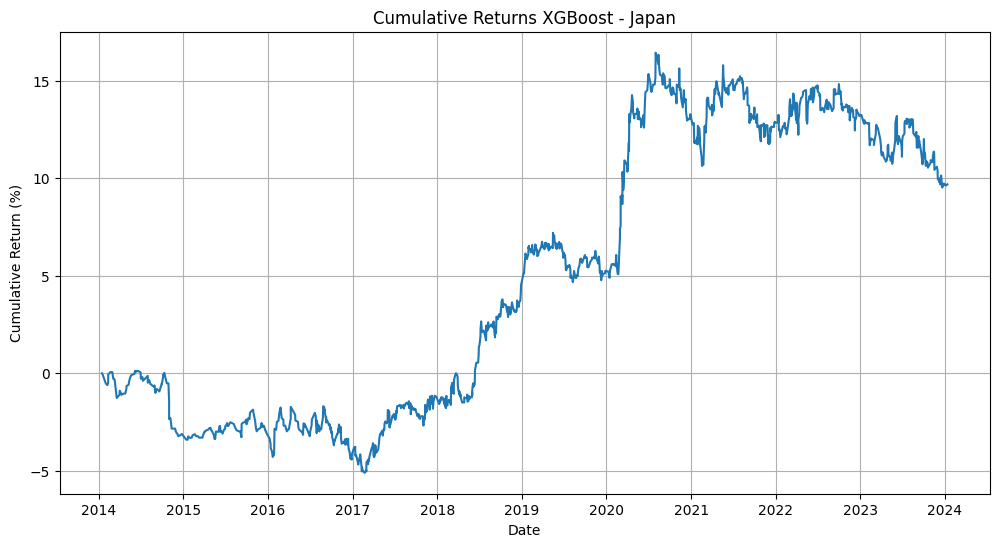

Final Cumulative Compounded Return: 9.69%

Overall Test Accuracy : 44.31%
Overall Precision: 34.12%
Overall Recall: 33.40%
Overall F1 Score: 33.40%

Average Fold Test Return : 0.00252%
Standard Deviation of All Test Returns (Aggregated Daily): 0.26590%
Minimum Return (Aggregated Daily): -0.92594%

--- Optimization Results ---

Optimal Horizon Counts:
(40 min)    10
Name: count, dtype: int64

Optimal Threshold Counts:
0.0    10
Name: count, dtype: int64

Test Set Position Counts (After Thresholding):
Neutral (0): 115
Long (1): 1595
Short (2): 1560


In [8]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['PYTHONHASHSEED'] = '0'

import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score
)
import numpy as np
import pandas as pd
import random

# Assume df_ml is pre-loaded as a pandas DataFrame from your file.

# --- Feature Columns ---
# This logic assumes the last 6 columns are the target/return columns.
# Adjust if your DataFrame structure is different.
feature_cols = df_ml.columns[:-6].tolist()
if 'DateTime' in feature_cols:
    feature_cols.remove('DateTime')
print("Feature Columns:", feature_cols)
print("Number of Features:", len(feature_cols))


# --- Configuration ---
total_cost = 2 * transaction_cost
horizons = [' (20 min)', ' (10 min)', ' (40 min)']
# MODIFICATION: Define a range of confidence thresholds to test
threshold_options = [0.0, 0.55, 0.65, 0.75, 0.85] # 0.0 means no threshold

# --- Data Prep ---
df_ml = df_ml.dropna(subset=['Surprise']).sort_values('DateTime')
min_date = df_ml['DateTime'].min()
max_date = df_ml['DateTime'].max()

# --- Calculate Initial Training Window ---
total_duration = max_date - min_date
initial_train_duration = total_duration * 0.3
train_start_date = min_date
train_end_date = min_date + initial_train_duration

# --- Tracking containers ---
all_test_returns = []
all_dates = []
all_test_preds = []
all_test_truths = []
all_test_probas = []
fold_mean_returns = []
best_horizons_list = []
# MODIFICATION: Add a list to track the best threshold for each fold
best_thresholds_list = []

def calculate_grouped_returns(df_group, horizon, stop_loss=None):
    """Calculate returns with position sizing and stop loss"""
    active_trades = df_group[df_group['pred'] != 0]
    if active_trades.empty:
        return 0.0

    longs = active_trades[active_trades['pred'] == 1].copy().reset_index(drop=True)
    shorts = active_trades[active_trades['pred'] == 2].copy().reset_index(drop=True)

    total_confidence = longs['proba'].sum() + shorts['proba'].sum()
    if total_confidence == 0:
        return 0.0

    num_trades = len(longs) + len(shorts)
    total_costs = total_cost * num_trades

    long_returns = 0.0
    short_returns = 0.0

    if not longs.empty:
        long_weights = longs['proba'] / total_confidence
        for idx in longs.index:
            raw_return = longs.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            long_returns += capped_raw * long_weights.loc[idx]

    if not shorts.empty:
        short_weights = shorts['proba'] / total_confidence
        for idx in shorts.index:
            raw_return = -shorts.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            short_returns += capped_raw * short_weights.loc[idx]

    net_return = (long_returns + short_returns) - total_costs
    return net_return


# --- Main Loop ---
while True:
    val_start_date = train_end_date + pd.DateOffset(days=1)
    val_end_date = val_start_date + pd.DateOffset(years=1)
    test_start_date = val_end_date + pd.DateOffset(days=1)
    test_end_date = test_start_date + pd.DateOffset(years=1)

    if val_end_date > max_date or test_end_date > max_date:
        break

    train_mask = (df_ml['DateTime'] >= train_start_date) & (df_ml['DateTime'] <= train_end_date)
    val_mask = (df_ml['DateTime'] >= val_start_date) & (df_ml['DateTime'] <= val_end_date)
    test_mask = (df_ml['DateTime'] >= test_start_date) & (df_ml['DateTime'] <= test_end_date)

    train_data = df_ml[train_mask]
    val_data = df_ml[val_mask]
    test_data = df_ml[test_mask]

    if val_data.empty or test_data.empty or train_data.empty:
        print(f"Skipping period starting {val_start_date.date()} (no data)")
        train_start_date += pd.DateOffset(years=1)
        train_end_date += pd.DateOffset(years=1)
        continue

    # --- Horizon and Threshold Optimization ---
    best_horizon, best_model, best_stop_loss, best_threshold = None, None, None, None
    best_val_return = -np.inf

    for horizon in horizons:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[feature_cols])
        X_val = scaler.transform(val_data[feature_cols])
        y_train = train_data[f'Target Signal{horizon}']
        
        model = xgb.XGBClassifier(
            num_class=3, n_estimators=60, max_depth=7,
            random_state=42, seed=42,
            # Suppress verbosity during the inner loop
            use_label_encoder=False, eval_metric='mlogloss'
        )
        model.fit(X_train, y_train, verbose=False)

        # --- MODIFICATION: Inner loop to find the best threshold ---
        for threshold in threshold_options:
            val_preds_original = model.predict(X_val)
            val_probas = model.predict_proba(X_val)
            
            # Filter predictions based on the confidence threshold
            max_probas = np.max(val_probas, axis=1)
            val_preds_filtered = np.where(max_probas >= threshold, val_preds_original, 0)
            
            # Create a DataFrame for validation with filtered predictions
            val_trade_df = pd.DataFrame({
                'DateTime': val_data['DateTime'],
                'pred': val_preds_filtered,
                'proba': [p[pred] for pred, p in zip(val_preds_original, val_probas)],
                f'Forward Return{horizon}': val_data[f'Forward Return{horizon}']
            })

            # Calculate stop-loss on the training data (this doesn't depend on the threshold)
            train_preds = model.predict(X_train)
            individual_train_returns = []
            train_returns_series = train_data[f'Forward Return{horizon}']
            for i, pred in enumerate(train_preds):
                if pred == 1:
                    individual_train_returns.append(train_returns_series.iloc[i])
                elif pred == 2:
                    individual_train_returns.append(-train_returns_series.iloc[i])
            stop_loss_train = np.percentile(individual_train_returns, 5) if individual_train_returns else None

            # Calculate returns on the validation set using the filtered predictions
            if stop_loss_train is not None:
                val_returns = val_trade_df.groupby('DateTime').apply(
                    lambda x: calculate_grouped_returns(x, horizon, stop_loss_train)
                ).values
                total_val_return = (1 + val_returns).prod() - 1

                if total_val_return > best_val_return:
                    best_val_return = total_val_return
                    best_horizon = horizon
                    best_model = model # Store the model trained for this horizon
                    best_threshold = threshold # Store the best threshold
                    
                    # Calculate and store the stop loss for the test set
                    individual_val_returns = []
                    val_returns_series = val_data[f'Forward Return{horizon}']
                    for i, pred in enumerate(val_preds_original): # Use original preds for SL calc
                         if pred == 1:
                            individual_val_returns.append(val_returns_series.iloc[i])
                         elif pred == 2:
                            individual_val_returns.append(-val_returns_series.iloc[i])
                    best_stop_loss = np.percentile(individual_val_returns, 5) if individual_val_returns else None


    # --- Test Best Model with Best Horizon and Threshold ---
    if best_model and best_stop_loss is not None and best_threshold is not None:
        X_test = scaler.transform(test_data[feature_cols])
        test_preds_original = best_model.predict(X_test)
        test_probas = best_model.predict_proba(X_test)
        y_test = test_data[f'Target Signal{best_horizon}'].values

        # MODIFICATION: Apply the optimized threshold to the test predictions
        max_probas_test = np.max(test_probas, axis=1)
        test_preds_filtered = np.where(max_probas_test >= best_threshold, test_preds_original, 0)

        test_trade_df = pd.DataFrame({
            'DateTime': test_data['DateTime'],
            'pred': test_preds_filtered, # Use filtered predictions for trading
            'proba': [p[pred] for pred, p in zip(test_preds_original, test_probas)],
            f'Forward Return{best_horizon}': test_data[f'Forward Return{best_horizon}']
        })

        grouped_returns = test_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, best_horizon, best_stop_loss)
        ).values

        all_test_returns.extend(grouped_returns)
        all_dates.extend(test_trade_df['DateTime'].unique().tolist())
        all_test_preds.extend(test_preds_filtered) # Store filtered predictions
        all_test_truths.extend(y_test)
        all_test_probas.append(test_probas)
        fold_mean_returns.append(np.mean(grouped_returns))
        best_horizons_list.append(best_horizon or 'standard')
        best_thresholds_list.append(best_threshold) # Track the chosen threshold

    # Slide the window forward
    train_start_date += pd.DateOffset(years=1)
    train_end_date += pd.DateOffset(years=1)

# --- Results ---
if all_test_returns:
    cumulative_returns = (1 + np.array(all_test_returns)).cumprod() - 1
    std_dev_individual = np.std(all_test_returns) * 100
    min_return = np.nanmin(all_test_returns) * 100 if all_test_returns else 0.0

    plt.figure(figsize=(12, 6))
    plt.plot(all_dates, cumulative_returns * 100)
    plt.title('Cumulative Returns XGBoost - Japan')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.show()

    print(f"Final Cumulative Compounded Return: {cumulative_returns[-1]*100:.2f}%")
    print(f"\nOverall Test Accuracy : {accuracy_score(all_test_truths, all_test_preds)*100:.2f}%")
    print(f"Overall Precision: {precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall Recall: {recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall F1 Score: {f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    # Note: ROC AUC should ideally be calculated on original probabilities before filtering
    # but for consistency with other metrics, we use the filtered predictions context.
    # print(f"Overall ROC AUC       : {roc_auc_score(all_test_truths, np.vstack(all_test_probas), multi_class='ovo', average='macro')*100:.2f}%")
    
    print(f"\nAverage Fold Test Return : {np.mean(fold_mean_returns)*100:.5f}%")
    print(f"Standard Deviation of All Test Returns (Aggregated Daily): {std_dev_individual:.5f}%")
    print(f"Minimum Return (Aggregated Daily): {min_return:.5f}%")
    
    print("\n--- Optimization Results ---")
    print("\nOptimal Horizon Counts:")
    print(pd.Series(best_horizons_list).value_counts())
    print("\nOptimal Threshold Counts:")
    print(pd.Series(best_thresholds_list).value_counts())
    
    print("\nTest Set Position Counts (After Thresholding):")
    counts = pd.Series(all_test_preds).value_counts().sort_index()
    print(f"Neutral (0): {counts.get(0, 0)}")
    print(f"Long (1): {counts.get(1, 0)}")
    print(f"Short (2): {counts.get(2, 0)}")

else:
    print("No valid test periods found")


In [9]:
# XGB confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Add this after your existing print statements
print("\nConfusion Matrix:")
cm = confusion_matrix(all_test_truths, all_test_preds)
cm_df = pd.DataFrame(cm,
                    index=['Actual Neutral (0)', 'Actual Long (1)', 'Actual Short (2)'],
                    columns=['Pred Neutral (0)', 'Pred Long (1)', 'Pred Short (2)'])
print(cm_df)

print("\nClassification Report:")
print(classification_report(all_test_truths, all_test_preds,
                           target_names=['Neutral (0)', 'Long (1)', 'Short (2)']))


Confusion Matrix:
                    Pred Neutral (0)  Pred Long (1)  Pred Short (2)
Actual Neutral (0)                13            127             100
Actual Long (1)                   55            716             740
Actual Short (2)                  47            752             720

Classification Report:
              precision    recall  f1-score   support

 Neutral (0)       0.11      0.05      0.07       240
    Long (1)       0.45      0.47      0.46      1511
   Short (2)       0.46      0.47      0.47      1519

    accuracy                           0.44      3270
   macro avg       0.34      0.33      0.33      3270
weighted avg       0.43      0.44      0.44      3270



<h1>Random Forest</h1>

Feature Columns: ['BOJDPBAL Index_Surprise', 'BOJDTR Index_Surprise', 'BOJTARMB Index_Surprise', 'JBSIBCLA Index_Surprise', 'JBSIBCLM Index_Surprise', 'JCOMACF Index_Surprise', 'JCOMHCF Index_Surprise', 'JCOMSHCF Index_Surprise', 'JCPNEFFE Index_Surprise', 'JFYFCPI2 Index_Surprise', 'JFYFCPIC Index_Surprise', 'JGDFDEFY Index_Surprise', 'JGDOQOQ Index_Surprise', 'JGDPAGDP Index_Surprise', 'JGDPCIQ Index_Surprise', 'JGDPCNEX Index_Surprise', 'JGDPCPIN Index_Surprise', 'JGDPPCQ Index_Surprise', 'JGDPQGDP Index_Surprise', 'JMNSM2Y Index_Surprise', 'JMNSM3Y Index_Surprise', 'JNBLBYOY Index_Surprise', 'JNBLENDA Index_Surprise', 'JNBPAB Index_Surprise', 'JNBPABA Index_Surprise', 'JNBPTRD Index_Surprise', 'JNCAPMOM Index_Surprise', 'JNCICCOI Index_Surprise', 'JNCICLEI Index_Surprise', 'JNCRPYOY Index_Surprise', 'JNCSTOTY Index_Surprise', 'JNFRTOTL Index_Surprise', 'JNHSAN Index_Surprise', 'JNHSYOY Index_Surprise', 'JNIPMOM Index_Surprise', 'JNIPYOY Index_Surprise', 'JNLSUCRE Index_Surprise', '

C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_12812\3150713113.py:173: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_12812\3150713113.py:173: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_12812\3150

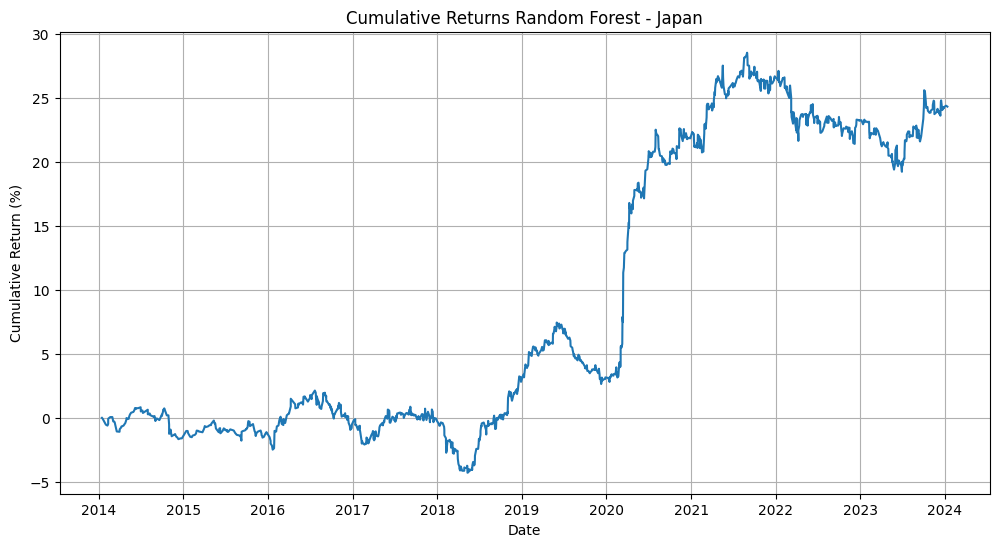

Final Cumulative Compounded Return: 24.33%

Overall Test Accuracy : 46.09%
Overall Precision: 30.74%
Overall Recall: 33.15%
Overall F1 Score: 31.85%
Overall ROC AUC: 49.13%

Average Fold Test Return : 0.01340%
Standard Deviation of All Test Returns (Aggregated Daily): 0.29283%
Minimum Return (Aggregated Daily): -0.72645%

--- Optimization Results ---

Optimal Horizon Counts:
(40 min)    10
Name: count, dtype: int64

Optimal Threshold Counts:
0.0    10
Name: count, dtype: int64

Test Set Position Counts (After Thresholding):
Neutral (0): 6
Long (1): 1498
Short (2): 1766


In [10]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['PYTHONHASHSEED'] = '0'

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score
)
import numpy as np
import pandas as pd
import random

# Assume df_ml is pre-loaded as a pandas DataFrame from your file.

# --- Feature Columns ---
# This logic assumes the last 6 columns are the target/return columns.
# Adjust if your DataFrame structure is different.
feature_cols = df_ml.columns[:-6].tolist()
if 'DateTime' in feature_cols:
    feature_cols.remove('DateTime')
print("Feature Columns:", feature_cols)
print("Number of Features:", len(feature_cols))


# --- Configuration ---
total_cost = 2 * transaction_cost
horizons = [' (20 min)', ' (10 min)', ' (40 min)']
# MODIFICATION: Define a range of confidence thresholds to test
threshold_options = [0.0, 0.55, 0.65, 0.75, 0.85] # 0.0 means no threshold

# --- Data Prep ---
df_ml = df_ml.dropna(subset=['Surprise']).sort_values('DateTime')
min_date = df_ml['DateTime'].min()
max_date = df_ml['DateTime'].max()

# --- Calculate Initial Training Window ---
total_duration = max_date - min_date
initial_train_duration = total_duration * 0.3
train_start_date = min_date
train_end_date = min_date + initial_train_duration

# --- Tracking containers ---
all_test_returns = []
all_dates = []
all_test_preds = []
all_test_truths = []
all_test_probas = []
fold_mean_returns = []
best_horizons_list = []
# MODIFICATION: Add a list to track the best threshold for each fold
best_thresholds_list = []

def calculate_grouped_returns(df_group, horizon, stop_loss=None):
    """Calculate returns with position sizing and stop loss"""
    active_trades = df_group[df_group['pred'] != 0]
    if active_trades.empty:
        return 0.0

    longs = active_trades[active_trades['pred'] == 1].copy().reset_index(drop=True)
    shorts = active_trades[active_trades['pred'] == 2].copy().reset_index(drop=True)

    total_confidence = longs['proba'].sum() + shorts['proba'].sum()
    if total_confidence == 0:
        return 0.0

    num_trades = len(longs) + len(shorts)
    total_costs = total_cost * num_trades

    long_returns = 0.0
    short_returns = 0.0

    if not longs.empty:
        long_weights = longs['proba'] / total_confidence
        for idx in longs.index:
            raw_return = longs.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            long_returns += capped_raw * long_weights.loc[idx]

    if not shorts.empty:
        short_weights = shorts['proba'] / total_confidence
        for idx in shorts.index:
            raw_return = -shorts.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            short_returns += capped_raw * short_weights.loc[idx]

    net_return = (long_returns + short_returns) - total_costs
    return net_return


# --- Main Loop ---
while True:
    val_start_date = train_end_date + pd.DateOffset(days=1)
    val_end_date = val_start_date + pd.DateOffset(years=1)
    test_start_date = val_end_date + pd.DateOffset(days=1)
    test_end_date = test_start_date + pd.DateOffset(years=1)

    if val_end_date > max_date or test_end_date > max_date:
        break

    train_mask = (df_ml['DateTime'] >= train_start_date) & (df_ml['DateTime'] <= train_end_date)
    val_mask = (df_ml['DateTime'] >= val_start_date) & (df_ml['DateTime'] <= val_end_date)
    test_mask = (df_ml['DateTime'] >= test_start_date) & (df_ml['DateTime'] <= test_end_date)

    train_data = df_ml[train_mask]
    val_data = df_ml[val_mask]
    test_data = df_ml[test_mask]

    if val_data.empty or test_data.empty or train_data.empty:
        print(f"Skipping period starting {val_start_date.date()} (no data)")
        train_start_date += pd.DateOffset(years=1)
        train_end_date += pd.DateOffset(years=1)
        continue

    # --- Horizon and Threshold Optimization ---
    best_horizon, best_model, best_stop_loss, best_scaler, best_threshold = None, None, None, None, None
    best_val_return = -np.inf

    for horizon in horizons:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[feature_cols])
        X_val = scaler.transform(val_data[feature_cols])
        y_train = train_data[f'Target Signal{horizon}']
        
        model = RandomForestClassifier(
            n_estimators=100,
            criterion='gini',
            min_samples_leaf=4,
            random_state=42
        )
        model.fit(X_train, y_train)

        # --- MODIFICATION: Inner loop to find the best threshold ---
        for threshold in threshold_options:
            val_preds_original = model.predict(X_val)
            val_probas = model.predict_proba(X_val)
            
            # Filter predictions based on the confidence threshold
            max_probas = np.max(val_probas, axis=1)
            val_preds_filtered = np.where(max_probas >= threshold, val_preds_original, 0)
            
            # ERROR FIX: Use a class_map dictionary for robust index lookup
            class_map = {cls: idx for idx, cls in enumerate(model.classes_)}
            val_trade_df = pd.DataFrame({
                'DateTime': val_data['DateTime'],
                'pred': val_preds_filtered,
                'proba': [p[class_map.get(pred)] for pred, p in zip(val_preds_original, val_probas)],
                f'Forward Return{horizon}': val_data[f'Forward Return{horizon}'].values
            })

            # Calculate stop-loss on the training data
            train_preds = model.predict(X_train)
            individual_train_returns = []
            train_returns_series = train_data[f'Forward Return{horizon}']
            for i, pred in enumerate(train_preds):
                if pred == 1:
                    individual_train_returns.append(train_returns_series.iloc[i])
                elif pred == 2:
                    individual_train_returns.append(-train_returns_series.iloc[i])
            stop_loss_train = np.percentile(individual_train_returns, 5) if individual_train_returns else None

            # Calculate returns on the validation set
            if stop_loss_train is not None:
                val_returns = val_trade_df.groupby('DateTime').apply(
                    lambda x: calculate_grouped_returns(x, horizon, stop_loss_train)
                ).values
                total_val_return = (1 + val_returns).prod() - 1

                if total_val_return > best_val_return:
                    best_val_return = total_val_return
                    best_horizon = horizon
                    best_model = model
                    best_threshold = threshold
                    best_scaler = scaler
                    
                    # Calculate and store the stop loss for the test set
                    individual_val_returns = []
                    val_returns_series = val_data[f'Forward Return{horizon}']
                    for i, pred in enumerate(val_preds_original):
                         if pred == 1:
                            individual_val_returns.append(val_returns_series.iloc[i])
                         elif pred == 2:
                            individual_val_returns.append(-val_returns_series.iloc[i])
                    best_stop_loss = np.percentile(individual_val_returns, 5) if individual_val_returns else None

    # --- Test Best Model with Best Horizon and Threshold ---
    if best_model and best_stop_loss is not None and best_threshold is not None:
        X_test = best_scaler.transform(test_data[feature_cols])
        test_preds_original = best_model.predict(X_test)
        test_probas = best_model.predict_proba(X_test)
        y_test = test_data[f'Target Signal{best_horizon}'].values

        # Apply the optimized threshold to the test predictions
        max_probas_test = np.max(test_probas, axis=1)
        test_preds_filtered = np.where(max_probas_test >= best_threshold, test_preds_original, 0)

        # ERROR FIX: Use a class_map dictionary for robust index lookup
        class_map = {cls: idx for idx, cls in enumerate(best_model.classes_)}
        test_trade_df = pd.DataFrame({
            'DateTime': test_data['DateTime'],
            'pred': test_preds_filtered,
            'proba': [p[class_map.get(pred)] for pred, p in zip(test_preds_original, test_probas)],
            f'Forward Return{best_horizon}': test_data[f'Forward Return{best_horizon}'].values
        })

        grouped_returns = test_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, best_horizon, best_stop_loss)
        ).values

        all_test_returns.extend(grouped_returns)
        all_dates.extend(test_trade_df['DateTime'].unique().tolist())
        all_test_preds.extend(test_preds_filtered)
        all_test_truths.extend(y_test)
        all_test_probas.append(test_probas)
        fold_mean_returns.append(np.mean(grouped_returns))
        best_horizons_list.append(best_horizon or 'standard')
        best_thresholds_list.append(best_threshold)

    # Slide the window forward
    train_start_date += pd.DateOffset(years=1)
    train_end_date += pd.DateOffset(years=1)

# --- Results ---
if all_test_returns:
    cumulative_returns = (1 + np.array(all_test_returns)).cumprod() - 1
    std_dev_individual = np.std(all_test_returns) * 100
    min_return = np.nanmin(all_test_returns) * 100 if all_test_returns else 0.0

    plt.figure(figsize=(12, 6))
    sorted_dates, sorted_returns = zip(*sorted(zip(all_dates, cumulative_returns)))
    plt.plot(sorted_dates, [r * 100 for r in sorted_returns])
    plt.title('Cumulative Returns Random Forest - Japan')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.show()

    print(f"Final Cumulative Compounded Return: {cumulative_returns[-1]*100:.2f}%")
    print(f"\nOverall Test Accuracy : {accuracy_score(all_test_truths, all_test_preds)*100:.2f}%")
    print(f"Overall Precision: {precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall Recall: {recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall F1 Score: {f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    if len(np.unique(all_test_truths)) > 1:
        # We need to handle the case where all predictions are neutral after filtering
        try:
            roc_auc = roc_auc_score(all_test_truths, np.vstack(all_test_probas), multi_class='ovo', average='macro')
            print(f"Overall ROC AUC: {roc_auc*100:.2f}%")
        except ValueError:
            print("Overall ROC AUC: Not enough classes in predictions for calculation.")
    else:
        print("Overall ROC AUC: Not enough classes in ground truth for calculation.")
    
    print(f"\nAverage Fold Test Return : {np.mean(fold_mean_returns)*100:.5f}%")
    print(f"Standard Deviation of All Test Returns (Aggregated Daily): {std_dev_individual:.5f}%")
    print(f"Minimum Return (Aggregated Daily): {min_return:.5f}%")
    
    print("\n--- Optimization Results ---")
    print("\nOptimal Horizon Counts:")
    print(pd.Series(best_horizons_list).value_counts())
    print("\nOptimal Threshold Counts:")
    print(pd.Series(best_thresholds_list).value_counts())
    
    print("\nTest Set Position Counts (After Thresholding):")
    counts = pd.Series(all_test_preds).value_counts().sort_index()
    print(f"Neutral (0): {counts.get(0, 0)}")
    print(f"Long (1): {counts.get(1, 0)}")
    print(f"Short (2): {counts.get(2, 0)}")

else:
    print("No valid test periods found")


In [11]:
# RF confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Add this after your existing print statements
print("\nConfusion Matrix:")
cm = confusion_matrix(all_test_truths, all_test_preds)
cm_df = pd.DataFrame(cm,
                    index=['Actual Neutral (0)', 'Actual Long (1)', 'Actual Short (2)'],
                    columns=['Pred Neutral (0)', 'Pred Long (1)', 'Pred Short (2)'])
print(cm_df)

print("\nClassification Report:")
print(classification_report(all_test_truths, all_test_preds,
                           target_names=['Neutral (0)', 'Long (1)', 'Short (2)']))


Confusion Matrix:
                    Pred Neutral (0)  Pred Long (1)  Pred Short (2)
Actual Neutral (0)                 0            128             112
Actual Long (1)                    6            679             826
Actual Short (2)                   0            691             828

Classification Report:
              precision    recall  f1-score   support

 Neutral (0)       0.00      0.00      0.00       240
    Long (1)       0.45      0.45      0.45      1511
   Short (2)       0.47      0.55      0.50      1519

    accuracy                           0.46      3270
   macro avg       0.31      0.33      0.32      3270
weighted avg       0.43      0.46      0.44      3270



<h1>Logistic Regression</h1>

Feature Columns: ['BOJDPBAL Index_Surprise', 'BOJDTR Index_Surprise', 'BOJTARMB Index_Surprise', 'JBSIBCLA Index_Surprise', 'JBSIBCLM Index_Surprise', 'JCOMACF Index_Surprise', 'JCOMHCF Index_Surprise', 'JCOMSHCF Index_Surprise', 'JCPNEFFE Index_Surprise', 'JFYFCPI2 Index_Surprise', 'JFYFCPIC Index_Surprise', 'JGDFDEFY Index_Surprise', 'JGDOQOQ Index_Surprise', 'JGDPAGDP Index_Surprise', 'JGDPCIQ Index_Surprise', 'JGDPCNEX Index_Surprise', 'JGDPCPIN Index_Surprise', 'JGDPPCQ Index_Surprise', 'JGDPQGDP Index_Surprise', 'JMNSM2Y Index_Surprise', 'JMNSM3Y Index_Surprise', 'JNBLBYOY Index_Surprise', 'JNBLENDA Index_Surprise', 'JNBPAB Index_Surprise', 'JNBPABA Index_Surprise', 'JNBPTRD Index_Surprise', 'JNCAPMOM Index_Surprise', 'JNCICCOI Index_Surprise', 'JNCICLEI Index_Surprise', 'JNCRPYOY Index_Surprise', 'JNCSTOTY Index_Surprise', 'JNFRTOTL Index_Surprise', 'JNHSAN Index_Surprise', 'JNHSYOY Index_Surprise', 'JNIPMOM Index_Surprise', 'JNIPYOY Index_Surprise', 'JNLSUCRE Index_Surprise', '

C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_12812\2899863154.py:179: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_12812\2899863154.py:179: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_12812\2899

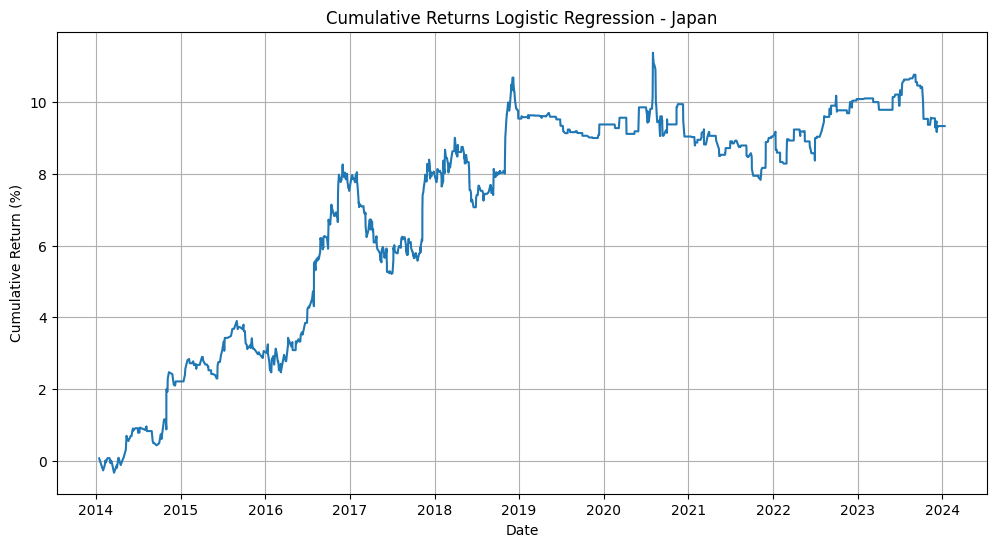

Final Cumulative Compounded Return: 9.33%

Overall Test Accuracy : 27.71%
Overall Precision: 31.26%
Overall Recall: 31.98%
Overall F1 Score: 27.34%
Overall ROC AUC: 51.85%

Average Fold Test Return : 0.00883%
Standard Deviation of All Test Returns (Aggregated Daily): 0.12863%
Minimum Return (Aggregated Daily): -0.46459%

--- Optimization Results ---

Optimal Horizon Counts:
(20 min)    5
(10 min)    4
(40 min)    1
Name: count, dtype: int64

Optimal Threshold Counts:
0.00    4
0.55    2
0.65    2
0.75    1
0.85    1
Name: count, dtype: int64

Test Set Position Counts (After Thresholding):
Neutral (0): 1522
Long (1): 900
Short (2): 848


In [12]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['PYTHONHASHSEED'] = '0'

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score
)
import numpy as np
import pandas as pd
import random

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Assume df_ml is pre-loaded as a pandas DataFrame from your file.

# --- Feature Columns ---
# This logic assumes the last 6 columns are the target/return columns.
# Adjust if your DataFrame structure is different.
feature_cols = df_ml.columns[:-6].tolist()
if 'DateTime' in feature_cols:
    feature_cols.remove('DateTime')
print("Feature Columns:", feature_cols)
print("Number of Features:", len(feature_cols))


# --- Configuration ---
total_cost = 2 * transaction_cost
horizons = [' (20 min)', ' (10 min)', ' (40 min)']
# MODIFICATION: Define a range of confidence thresholds to test
threshold_options = [0.0, 0.55, 0.65, 0.75, 0.85] # 0.0 means no threshold

# --- Data Prep ---
df_ml = df_ml.dropna(subset=['Surprise']).sort_values('DateTime')
min_date = df_ml['DateTime'].min()
max_date = df_ml['DateTime'].max()

# --- Calculate Initial Training Window ---
total_duration = max_date - min_date
initial_train_duration = total_duration * 0.3
train_start_date = min_date
train_end_date = min_date + initial_train_duration

# --- Tracking containers ---
all_test_returns = []
all_dates = []
all_test_preds = []
all_test_truths = []
all_test_probas = []
fold_mean_returns = []
best_horizons_list = []
# MODIFICATION: Add a list to track the best threshold for each fold
best_thresholds_list = []

def calculate_grouped_returns(df_group, horizon, stop_loss=None):
    """Calculate returns with position sizing and stop loss"""
    active_trades = df_group[df_group['pred'] != 0]
    if active_trades.empty:
        return 0.0

    longs = active_trades[active_trades['pred'] == 1].copy().reset_index(drop=True)
    shorts = active_trades[active_trades['pred'] == 2].copy().reset_index(drop=True)

    total_confidence = longs['proba'].sum() + shorts['proba'].sum()
    if total_confidence == 0:
        return 0.0

    num_trades = len(longs) + len(shorts)
    total_costs = total_cost * num_trades

    long_returns = 0.0
    short_returns = 0.0

    if not longs.empty:
        long_weights = longs['proba'] / total_confidence
        for idx in longs.index:
            raw_return = longs.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            long_returns += capped_raw * long_weights.loc[idx]

    if not shorts.empty:
        short_weights = shorts['proba'] / total_confidence
        for idx in shorts.index:
            raw_return = -shorts.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            short_returns += capped_raw * short_weights.loc[idx]

    net_return = (long_returns + short_returns) - total_costs
    return net_return


# --- Main Loop ---
while True:
    val_start_date = train_end_date + pd.DateOffset(days=1)
    val_end_date = val_start_date + pd.DateOffset(years=1)
    test_start_date = val_end_date + pd.DateOffset(days=1)
    test_end_date = test_start_date + pd.DateOffset(years=1)

    if val_end_date > max_date or test_end_date > max_date:
        break

    train_mask = (df_ml['DateTime'] >= train_start_date) & (df_ml['DateTime'] <= train_end_date)
    val_mask = (df_ml['DateTime'] >= val_start_date) & (df_ml['DateTime'] <= val_end_date)
    test_mask = (df_ml['DateTime'] >= test_start_date) & (df_ml['DateTime'] <= test_end_date)

    train_data = df_ml[train_mask]
    val_data = df_ml[val_mask]
    test_data = df_ml[test_mask]

    if val_data.empty or test_data.empty or train_data.empty:
        print(f"Skipping period starting {val_start_date.date()} (no data)")
        train_start_date += pd.DateOffset(years=1)
        train_end_date += pd.DateOffset(years=1)
        continue

    # --- Horizon and Threshold Optimization ---
    # ERROR FIX: Added best_scaler to tracking
    best_horizon, best_model, best_stop_loss, best_scaler, best_threshold = None, None, None, None, None
    best_val_return = -np.inf

    for horizon in horizons:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[feature_cols])
        X_val = scaler.transform(val_data[feature_cols])
        y_train = train_data[f'Target Signal{horizon}']
        
        model = LogisticRegression(
            multi_class='multinomial',
            solver='saga',
            max_iter=1000, # Increased for convergence
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)

        # --- MODIFICATION: Inner loop to find the best threshold ---
        for threshold in threshold_options:
            val_preds_original = model.predict(X_val)
            val_probas = model.predict_proba(X_val)
            
            # Filter predictions based on the confidence threshold
            max_probas = np.max(val_probas, axis=1)
            val_preds_filtered = np.where(max_probas >= threshold, val_preds_original, 0)
            
            # ERROR FIX: Use a class_map dictionary for robust index lookup
            class_map = {cls: idx for idx, cls in enumerate(model.classes_)}
            val_trade_df = pd.DataFrame({
                'DateTime': val_data['DateTime'],
                'pred': val_preds_filtered,
                'proba': [p[class_map.get(pred)] for pred, p in zip(val_preds_original, val_probas)],
                f'Forward Return{horizon}': val_data[f'Forward Return{horizon}'].values
            })

            # Calculate stop-loss on the training data
            train_preds = model.predict(X_train)
            individual_train_returns = []
            train_returns_series = train_data[f'Forward Return{horizon}']
            for i, pred in enumerate(train_preds):
                if pred == 1:
                    individual_train_returns.append(train_returns_series.iloc[i])
                elif pred == 2:
                    individual_train_returns.append(-train_returns_series.iloc[i])
            stop_loss_train = np.percentile(individual_train_returns, 5) if individual_train_returns else None

            # Calculate returns on the validation set
            if stop_loss_train is not None:
                val_returns = val_trade_df.groupby('DateTime').apply(
                    lambda x: calculate_grouped_returns(x, horizon, stop_loss_train)
                ).values
                total_val_return = (1 + val_returns).prod() - 1

                if total_val_return > best_val_return:
                    best_val_return = total_val_return
                    best_horizon = horizon
                    best_model = model
                    best_threshold = threshold
                    best_scaler = scaler # ERROR FIX: Store the best scaler
                    
                    # Calculate and store the stop loss for the test set
                    individual_val_returns = []
                    val_returns_series = val_data[f'Forward Return{horizon}']
                    for i, pred in enumerate(val_preds_original):
                         if pred == 1:
                            individual_val_returns.append(val_returns_series.iloc[i])
                         elif pred == 2:
                            individual_val_returns.append(-val_returns_series.iloc[i])
                    best_stop_loss = np.percentile(individual_val_returns, 5) if individual_val_returns else None

    # --- Test Best Model with Best Horizon and Threshold ---
    if best_model and best_stop_loss is not None and best_threshold is not None:
        # ERROR FIX: Use the best_scaler associated with the best model
        X_test = best_scaler.transform(test_data[feature_cols])
        test_preds_original = best_model.predict(X_test)
        test_probas = best_model.predict_proba(X_test)
        y_test = test_data[f'Target Signal{best_horizon}'].values

        # Apply the optimized threshold to the test predictions
        max_probas_test = np.max(test_probas, axis=1)
        test_preds_filtered = np.where(max_probas_test >= best_threshold, test_preds_original, 0)

        # ERROR FIX: Use a class_map dictionary for robust index lookup
        class_map = {cls: idx for idx, cls in enumerate(best_model.classes_)}
        test_trade_df = pd.DataFrame({
            'DateTime': test_data['DateTime'],
            'pred': test_preds_filtered,
            'proba': [p[class_map.get(pred)] for pred, p in zip(test_preds_original, test_probas)],
            f'Forward Return{best_horizon}': test_data[f'Forward Return{best_horizon}'].values
        })

        grouped_returns = test_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, best_horizon, best_stop_loss)
        ).values

        all_test_returns.extend(grouped_returns)
        all_dates.extend(test_trade_df['DateTime'].unique().tolist())
        all_test_preds.extend(test_preds_filtered)
        all_test_truths.extend(y_test)
        all_test_probas.append(test_probas)
        fold_mean_returns.append(np.mean(grouped_returns))
        best_horizons_list.append(best_horizon or 'standard')
        best_thresholds_list.append(best_threshold)

    # Slide the window forward
    train_start_date += pd.DateOffset(years=1)
    train_end_date += pd.DateOffset(years=1)

# --- Results ---
if all_test_returns:
    cumulative_returns = (1 + np.array(all_test_returns)).cumprod() - 1
    std_dev_individual = np.std(all_test_returns) * 100
    min_return = np.nanmin(all_test_returns) * 100 if all_test_returns else 0.0

    plt.figure(figsize=(12, 6))
    sorted_dates, sorted_returns = zip(*sorted(zip(all_dates, cumulative_returns)))
    plt.plot(sorted_dates, [r * 100 for r in sorted_returns])
    plt.title('Cumulative Returns Logistic Regression - Japan')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.show()

    print(f"Final Cumulative Compounded Return: {cumulative_returns[-1]*100:.2f}%")
    print(f"\nOverall Test Accuracy : {accuracy_score(all_test_truths, all_test_preds)*100:.2f}%")
    print(f"Overall Precision: {precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall Recall: {recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall F1 Score: {f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    if len(np.unique(all_test_truths)) > 1:
        try:
            roc_auc = roc_auc_score(all_test_truths, np.vstack(all_test_probas), multi_class='ovo', average='macro')
            print(f"Overall ROC AUC: {roc_auc*100:.2f}%")
        except ValueError:
            print("Overall ROC AUC: Not enough classes in predictions for calculation.")
    else:
        print("Overall ROC AUC: Not enough classes in ground truth for calculation.")
    
    print(f"\nAverage Fold Test Return : {np.mean(fold_mean_returns)*100:.5f}%")
    print(f"Standard Deviation of All Test Returns (Aggregated Daily): {std_dev_individual:.5f}%")
    print(f"Minimum Return (Aggregated Daily): {min_return:.5f}%")
    
    print("\n--- Optimization Results ---")
    print("\nOptimal Horizon Counts:")
    print(pd.Series(best_horizons_list).value_counts())
    print("\nOptimal Threshold Counts:")
    print(pd.Series(best_thresholds_list).value_counts())
    
    print("\nTest Set Position Counts (After Thresholding):")
    counts = pd.Series(all_test_preds).value_counts().sort_index()
    print(f"Neutral (0): {counts.get(0, 0)}")
    print(f"Long (1): {counts.get(1, 0)}")
    print(f"Short (2): {counts.get(2, 0)}")

else:
    print("No valid test periods found")


In [13]:
# LR confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Add this after your existing print statements
print("\nConfusion Matrix:")
cm = confusion_matrix(all_test_truths, all_test_preds)
cm_df = pd.DataFrame(cm,
                    index=['Actual Neutral (0)', 'Actual Long (1)', 'Actual Short (2)'],
                    columns=['Pred Neutral (0)', 'Pred Long (1)', 'Pred Short (2)'])
print(cm_df)

print("\nClassification Report:")
print(classification_report(all_test_truths, all_test_preds,
                           target_names=['Neutral (0)', 'Long (1)', 'Short (2)']))


Confusion Matrix:
                    Pred Neutral (0)  Pred Long (1)  Pred Short (2)
Actual Neutral (0)               201            123             111
Actual Long (1)                  638            376             408
Actual Short (2)                 683            401             329

Classification Report:
              precision    recall  f1-score   support

 Neutral (0)       0.13      0.46      0.21       435
    Long (1)       0.42      0.26      0.32      1422
   Short (2)       0.39      0.23      0.29      1413

    accuracy                           0.28      3270
   macro avg       0.31      0.32      0.27      3270
weighted avg       0.37      0.28      0.29      3270



<h1>LSTM</h1>


Feature Columns: ['BOJDPBAL Index_Surprise', 'BOJDTR Index_Surprise', 'BOJTARMB Index_Surprise', 'JBSIBCLA Index_Surprise', 'JBSIBCLM Index_Surprise', 'JCOMACF Index_Surprise', 'JCOMHCF Index_Surprise', 'JCOMSHCF Index_Surprise', 'JCPNEFFE Index_Surprise', 'JFYFCPI2 Index_Surprise', 'JFYFCPIC Index_Surprise', 'JGDFDEFY Index_Surprise', 'JGDOQOQ Index_Surprise', 'JGDPAGDP Index_Surprise', 'JGDPCIQ Index_Surprise', 'JGDPCNEX Index_Surprise', 'JGDPCPIN Index_Surprise', 'JGDPPCQ Index_Surprise', 'JGDPQGDP Index_Surprise', 'JMNSM2Y Index_Surprise', 'JMNSM3Y Index_Surprise', 'JNBLBYOY Index_Surprise', 'JNBLENDA Index_Surprise', 'JNBPAB Index_Surprise', 'JNBPABA Index_Surprise', 'JNBPTRD Index_Surprise', 'JNCAPMOM Index_Surprise', 'JNCICCOI Index_Surprise', 'JNCICLEI Index_Surprise', 'JNCRPYOY Index_Surprise', 'JNCSTOTY Index_Surprise', 'JNFRTOTL Index_Surprise', 'JNHSAN Index_Surprise', 'JNHSYOY Index_Surprise', 'JNIPMOM Index_Surprise', 'JNIPYOY Index_Surprise', 'JNLSUCRE Index_Surprise', 

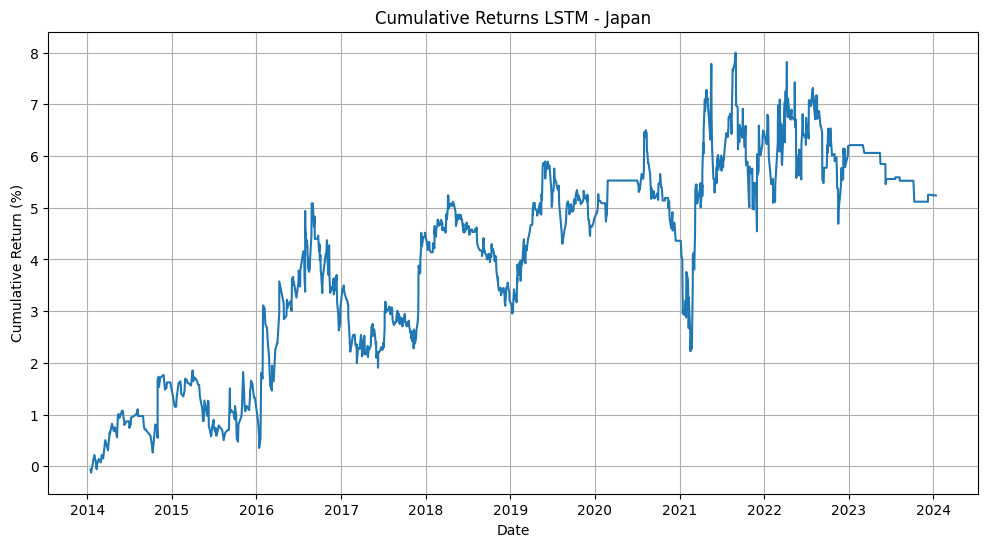

Final Cumulative Compounded Return: 5.24%

Overall Test Accuracy : 36.39%
Overall Precision: 31.76%
Overall Recall: 31.22%
Overall F1 Score: 28.75%
Overall ROC AUC: 55.46%

Average Fold Test Return : 0.00486%
Standard Deviation of All Test Returns (Aggregated Daily): 0.21241%
Minimum Return (Aggregated Daily): -0.72545%

--- Optimization Results ---

Optimal Horizon Counts:
(40 min)    4
(20 min)    4
(10 min)    2
Name: count, dtype: int64

Optimal Threshold Counts:
0.00    8
0.55    1
0.65    1
Name: count, dtype: int64

Test Set Position Counts (After Thresholding):
Neutral (0): 662
Long (1): 573
Short (2): 2035


In [14]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress TensorFlow INFO and WARNING messages

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score
)
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# --- MODIFICATION: Suppress Deprecation Warnings ---
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Assume df_ml is pre-loaded as a pandas DataFrame in your environment.

# --- Feature Engineering ---
all_cols = df_ml.columns.tolist()
exclude_cols = ['DateTime', 'Surprise'] + [col for col in all_cols if 'Target' in col or 'Forward' in col]
feature_cols = [col for col in all_cols if col not in exclude_cols]
print("Feature Columns:", feature_cols)
print("Number of Features:", len(feature_cols))


# --- Configuration ---
total_cost = 2 * transaction_cost
horizons = [' (20 min)', ' (10 min)', ' (40 min)']
N_CLASSES = 3 # Assuming classes are 0, 1, 2
# MODIFICATION: Define a range of confidence thresholds to test
threshold_options = [0.0, 0.55, 0.65, 0.75, 0.85] # 0.0 means no threshold

# --- Data Prep ---
df_ml = df_ml.dropna(subset=['Surprise']).sort_values('DateTime')
min_date = df_ml['DateTime'].min()
max_date = df_ml['DateTime'].max()

# --- Calculate Initial Training Window ---
total_duration = max_date - min_date
initial_train_duration = total_duration * 0.3
train_start_date = min_date
train_end_date = min_date + initial_train_duration

# --- Tracking containers ---
all_test_returns = []
all_dates = []
all_test_preds = []
all_test_truths = []
all_test_probas = []
fold_mean_returns = []
best_horizons_list = []
# MODIFICATION: Add a list to track the best threshold for each fold
best_thresholds_list = []

def create_lstm_model(input_shape, num_classes):
    """Creates a simple LSTM model."""
    model = Sequential([
        LSTM(50, input_shape=input_shape, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def calculate_grouped_returns(df_group, horizon, stop_loss=None):
    """Calculate returns with position sizing and stop loss"""
    active_trades = df_group[df_group['pred'] != 0]
    if active_trades.empty:
        return 0.0

    longs = active_trades[active_trades['pred'] == 1].copy().reset_index(drop=True)
    shorts = active_trades[active_trades['pred'] == 2].copy().reset_index(drop=True)

    total_confidence = longs['proba'].sum() + shorts['proba'].sum()
    if total_confidence == 0:
        return 0.0

    num_trades = len(longs) + len(shorts)
    total_costs = total_cost * num_trades

    long_returns = 0.0
    short_returns = 0.0

    if not longs.empty:
        long_weights = longs['proba'] / total_confidence
        for idx in longs.index:
            raw_return = longs.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            long_returns += capped_raw * long_weights.loc[idx]

    if not shorts.empty:
        short_weights = shorts['proba'] / total_confidence
        for idx in shorts.index:
            raw_return = -shorts.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            short_returns += capped_raw * short_weights.loc[idx]

    net_return = (long_returns + short_returns) - total_costs
    return net_return

# --- Main Loop ---
while True:
    val_start_date = train_end_date + pd.DateOffset(days=1)
    val_end_date = val_start_date + pd.DateOffset(years=1)
    test_start_date = val_end_date + pd.DateOffset(days=1)
    test_end_date = test_start_date + pd.DateOffset(years=1)

    if val_end_date > max_date or test_end_date > max_date:
        break

    train_mask = (df_ml['DateTime'] >= train_start_date) & (df_ml['DateTime'] <= train_end_date)
    val_mask = (df_ml['DateTime'] >= val_start_date) & (df_ml['DateTime'] <= val_end_date)
    test_mask = (df_ml['DateTime'] >= test_start_date) & (df_ml['DateTime'] <= test_end_date)

    train_data = df_ml[train_mask]
    val_data = df_ml[val_mask]
    test_data = df_ml[test_mask]

    if val_data.empty or test_data.empty or train_data.empty:
        # This print is okay as it only happens if a whole year is skipped
        print(f"Skipping period starting {val_start_date.date()} (no data)")
        train_start_date += pd.DateOffset(years=1)
        train_end_date += pd.DateOffset(years=1)
        continue

    # --- Horizon and Threshold Optimization ---
    best_horizon, best_model, best_stop_loss, best_scaler, best_threshold = None, None, None, None, None
    best_val_return = -np.inf

    for horizon in horizons:
        # --- MODIFICATION: Commented out the verbose print statement ---
        # print(f"\nEvaluating Horizon: {horizon} for training period {train_start_date.date()} to {train_end_date.date()}")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(train_data[feature_cols])
        X_val_scaled = scaler.transform(val_data[feature_cols])

        X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
        X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

        y_train = train_data[f'Target Signal{horizon}']
        y_train_cat = to_categorical(y_train, num_classes=N_CLASSES)
        y_val_cat = to_categorical(val_data[f'Target Signal{horizon}'], num_classes=N_CLASSES)

        model = create_lstm_model(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), num_classes=N_CLASSES)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(X_train_reshaped, y_train_cat,
                  validation_data=(X_val_reshaped, y_val_cat),
                  epochs=50,
                  batch_size=32,
                  callbacks=[early_stopping],
                  verbose=0)

        # --- MODIFICATION: Inner loop to find the best threshold ---
        for threshold in threshold_options:
            # --- MODIFICATION: Added verbose=0 to model.predict ---
            val_probas = model.predict(X_val_reshaped, verbose=0)
            val_preds_original = np.argmax(val_probas, axis=1)

            max_probas = np.max(val_probas, axis=1)
            val_preds_filtered = np.where(max_probas >= threshold, val_preds_original, 0)

            val_trade_df = pd.DataFrame({
                'DateTime': val_data['DateTime'],
                'pred': val_preds_filtered,
                'proba': [p[pred] for pred, p in zip(val_preds_original, val_probas)],
                f'Forward Return{horizon}': val_data[f'Forward Return{horizon}'].values
            })

            # --- MODIFICATION: Added verbose=0 to model.predict ---
            train_probas = model.predict(X_train_reshaped, verbose=0)
            train_preds = np.argmax(train_probas, axis=1)
            individual_train_returns = []
            train_returns_series = train_data[f'Forward Return{horizon}']
            for i, pred in enumerate(train_preds):
                if pred == 1:
                    individual_train_returns.append(train_returns_series.iloc[i])
                elif pred == 2:
                    individual_train_returns.append(-train_returns_series.iloc[i])
            stop_loss_train = np.percentile(individual_train_returns, 5) if individual_train_returns else None

            if stop_loss_train is not None:
                val_returns = val_trade_df.groupby('DateTime').apply(
                    lambda x: calculate_grouped_returns(x, horizon, stop_loss_train)
                ).values
                total_val_return = (1 + val_returns).prod() - 1

                if total_val_return > best_val_return:
                    best_val_return = total_val_return
                    best_horizon = horizon
                    best_model = model
                    best_threshold = threshold
                    best_scaler = scaler
                    
                    individual_val_returns = []
                    val_returns_series = val_data[f'Forward Return{horizon}']
                    for i, pred in enumerate(val_preds_original):
                         if pred == 1:
                            individual_val_returns.append(val_returns_series.iloc[i])
                         elif pred == 2:
                            individual_val_returns.append(-val_returns_series.iloc[i])
                    best_stop_loss = np.percentile(individual_val_returns, 5) if individual_val_returns else None

    # --- Test Best Model ---
    if best_model and best_stop_loss is not None and best_threshold is not None:
        # --- MODIFICATION: Commented out the verbose print statement ---
        # print(f"\n--- Testing best model for period ending {test_end_date.date()} ---")
        # print(f"Best Horizon: {best_horizon}, Best Threshold: {best_threshold}")
        
        X_test_scaled = best_scaler.transform(test_data[feature_cols])
        X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
        
        # --- MODIFICATION: Added verbose=0 to model.predict ---
        test_probas = best_model.predict(X_test_reshaped, verbose=0)
        test_preds_original = np.argmax(test_probas, axis=1)
        y_test = test_data[f'Target Signal{best_horizon}'].values

        max_probas_test = np.max(test_probas, axis=1)
        test_preds_filtered = np.where(max_probas_test >= best_threshold, test_preds_original, 0)

        test_trade_df = pd.DataFrame({
            'DateTime': test_data['DateTime'],
            'pred': test_preds_filtered,
            'proba': [p[pred] for pred, p in zip(test_preds_original, test_probas)],
            f'Forward Return{best_horizon}': test_data[f'Forward Return{best_horizon}'].values
        })

        grouped_returns = test_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, best_horizon, best_stop_loss)
        ).values

        all_test_returns.extend(grouped_returns)
        all_dates.extend(test_trade_df['DateTime'].unique().tolist())
        all_test_preds.extend(test_preds_filtered)
        all_test_truths.extend(y_test)
        all_test_probas.append(test_probas)
        fold_mean_returns.append(np.mean(grouped_returns))
        best_horizons_list.append(best_horizon or 'standard')
        best_thresholds_list.append(best_threshold)

    train_start_date += pd.DateOffset(years=1)
    train_end_date += pd.DateOffset(years=1)

# --- Results ---
if all_test_returns:
    cumulative_returns = (1 + np.array(all_test_returns)).cumprod() - 1
    std_dev_individual = np.std(all_test_returns) * 100
    min_return = np.nanmin(all_test_returns) * 100 if all_test_returns else 0.0

    plt.figure(figsize=(12, 6))
    sorted_dates, sorted_returns = zip(*sorted(zip(all_dates, cumulative_returns)))
    plt.plot(sorted_dates, [r * 100 for r in sorted_returns])
    plt.title('Cumulative Returns LSTM - Japan')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.show()

    full_probas = np.vstack(all_test_probas)
    y_test_cat = to_categorical(all_test_truths, num_classes=N_CLASSES)

    print(f"Final Cumulative Compounded Return: {cumulative_returns[-1]*100:.2f}%")
    print(f"\nOverall Test Accuracy : {accuracy_score(all_test_truths, all_test_preds)*100:.2f}%")
    print(f"Overall Precision: {precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall Recall: {recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall F1 Score: {f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    if len(np.unique(all_test_truths)) > 1:
        try:
            roc_auc = roc_auc_score(y_test_cat, full_probas, multi_class='ovo', average='macro')
            print(f"Overall ROC AUC: {roc_auc*100:.2f}%")
        except ValueError:
             print("Overall ROC AUC: Not enough classes in predictions for calculation.")
    else:
        print("Overall ROC AUC: Not enough classes in ground truth for calculation.")
        
    print(f"\nAverage Fold Test Return : {np.mean(fold_mean_returns)*100:.5f}%")
    print(f"Standard Deviation of All Test Returns (Aggregated Daily): {std_dev_individual:.5f}%")
    print(f"Minimum Return (Aggregated Daily): {min_return:.5f}%")

    print("\n--- Optimization Results ---")
    print("\nOptimal Horizon Counts:")
    print(pd.Series(best_horizons_list).value_counts())
    print("\nOptimal Threshold Counts:")
    print(pd.Series(best_thresholds_list).value_counts())

    print("\nTest Set Position Counts (After Thresholding):")
    counts = pd.Series(all_test_preds).value_counts().sort_index()
    print(f"Neutral (0): {counts.get(0, 0)}")
    print(f"Long (1): {counts.get(1, 0)}")
    print(f"Short (2): {counts.get(2, 0)}")

else:
    print("No valid test periods found")


In [15]:
print("\nConfusion Matrix:")
cm = confusion_matrix(all_test_truths, all_test_preds)
cm_df = pd.DataFrame(cm,
                        index=['Actual Neutral (0)', 'Actual Long (1)', 'Actual Short (2)'],
                        columns=['Pred Neutral (0)', 'Pred Long (1)', 'Pred Short (2)'])
print(cm_df)

print("\nClassification Report:")
print(classification_report(all_test_truths, all_test_preds,
                                target_names=['Neutral (0)', 'Long (1)', 'Short (2)']))


Confusion Matrix:
                    Pred Neutral (0)  Pred Long (1)  Pred Short (2)
Actual Neutral (0)                56             74             245
Actual Long (1)                  308            248             904
Actual Short (2)                 298            251             886

Classification Report:
              precision    recall  f1-score   support

 Neutral (0)       0.08      0.15      0.11       375
    Long (1)       0.43      0.17      0.24      1460
   Short (2)       0.44      0.62      0.51      1435

    accuracy                           0.36      3270
   macro avg       0.32      0.31      0.29      3270
weighted avg       0.39      0.36      0.35      3270



<h1>SVM</h1>

Feature Columns: ['BOJDPBAL Index_Surprise', 'BOJDTR Index_Surprise', 'BOJTARMB Index_Surprise', 'JBSIBCLA Index_Surprise', 'JBSIBCLM Index_Surprise', 'JCOMACF Index_Surprise', 'JCOMHCF Index_Surprise', 'JCOMSHCF Index_Surprise', 'JCPNEFFE Index_Surprise', 'JFYFCPI2 Index_Surprise', 'JFYFCPIC Index_Surprise', 'JGDFDEFY Index_Surprise', 'JGDOQOQ Index_Surprise', 'JGDPAGDP Index_Surprise', 'JGDPCIQ Index_Surprise', 'JGDPCNEX Index_Surprise', 'JGDPCPIN Index_Surprise', 'JGDPPCQ Index_Surprise', 'JGDPQGDP Index_Surprise', 'JMNSM2Y Index_Surprise', 'JMNSM3Y Index_Surprise', 'JNBLBYOY Index_Surprise', 'JNBLENDA Index_Surprise', 'JNBPAB Index_Surprise', 'JNBPABA Index_Surprise', 'JNBPTRD Index_Surprise', 'JNCAPMOM Index_Surprise', 'JNCICCOI Index_Surprise', 'JNCICLEI Index_Surprise', 'JNCRPYOY Index_Surprise', 'JNCSTOTY Index_Surprise', 'JNFRTOTL Index_Surprise', 'JNHSAN Index_Surprise', 'JNHSYOY Index_Surprise', 'JNIPMOM Index_Surprise', 'JNIPYOY Index_Surprise', 'JNLSUCRE Index_Surprise', '

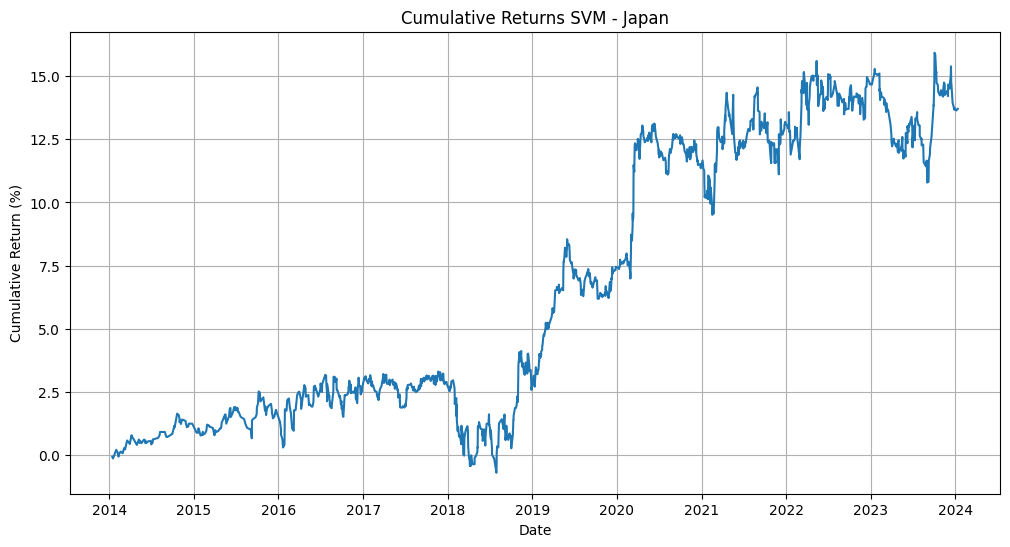

Final Cumulative Compounded Return: 13.70%

Overall Test Accuracy : 45.72%
Overall Precision: 30.50%
Overall Recall: 33.27%
Overall F1 Score: 31.81%
Overall ROC AUC: 52.35%

Average Fold Test Return : 0.01032%
Standard Deviation of All Test Returns (Aggregated Daily): 0.25808%
Minimum Return (Aggregated Daily): -0.83168%

--- Optimization Results ---

Optimal Horizon Counts:
(40 min)    7
(20 min)    2
(10 min)    1
Name: count, dtype: int64

Optimal Threshold Counts:
0.0    10
Name: count, dtype: int64

Test Set Position Counts (After Thresholding):
Neutral (0): 0
Long (1): 1704
Short (2): 1566

Confusion Matrix:
                    Pred Neutral (0)  Pred Long (1)  Pred Short (2)
Actual Neutral (0)                 0            163             111
Actual Long (1)                    0            765             725
Actual Short (2)                   0            776             730

Classification Report:
              precision    recall  f1-score   support

 Neutral (0)       0.00    

In [16]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['PYTHONHASHSEED'] = '0'

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)
import numpy as np
import pandas as pd
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Assume df_ml is pre-loaded as a pandas DataFrame in your environment.

# --- Feature Engineering ---
all_cols = df_ml.columns.tolist()
exclude_cols = ['DateTime', 'Surprise'] + [col for col in all_cols if 'Target' in col or 'Forward' in col]
feature_cols = [col for col in all_cols if col not in exclude_cols]
print("Feature Columns:", feature_cols)
print("Number of Features:", len(feature_cols))


# --- Configuration ---
total_cost = 2 * transaction_cost
horizons = [' (20 min)', ' (10 min)', ' (40 min)']
# MODIFICATION: Define a range of confidence thresholds to test
threshold_options = [0.0, 0.55, 0.65, 0.75, 0.85] # 0.0 means no threshold

# --- Data Prep ---
df_ml = df_ml.dropna(subset=['Surprise']).sort_values('DateTime')
min_date = df_ml['DateTime'].min()
max_date = df_ml['DateTime'].max()

# --- Calculate Initial Training Window ---
total_duration = max_date - min_date
initial_train_duration = total_duration * 0.3
train_start_date = min_date
train_end_date = min_date + initial_train_duration


# --- Tracking containers ---
all_test_returns = []
all_dates = []
all_test_preds = []
all_test_truths = []
all_test_probas = []
fold_mean_returns = []
best_horizons_list = []
# MODIFICATION: Add a list to track the best threshold for each fold
best_thresholds_list = []


def calculate_grouped_returns(df_group, horizon, stop_loss=None):
    """Calculate returns with position sizing and stop loss"""
    active_trades = df_group[df_group['pred'] != 0]
    if active_trades.empty:
        return 0.0

    longs = active_trades[active_trades['pred'] == 1].copy().reset_index(drop=True)
    shorts = active_trades[active_trades['pred'] == 2].copy().reset_index(drop=True)

    total_confidence = longs['proba'].sum() + shorts['proba'].sum()
    if total_confidence == 0:
        return 0.0

    num_trades = len(longs) + len(shorts)
    total_costs = total_cost * num_trades

    long_returns = 0.0
    short_returns = 0.0

    if not longs.empty:
        long_weights = longs['proba'] / total_confidence
        for idx in longs.index:
            raw_return = longs.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            long_returns += capped_raw * long_weights.loc[idx]

    if not shorts.empty:
        short_weights = shorts['proba'] / total_confidence
        for idx in shorts.index:
            raw_return = -shorts.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            short_returns += capped_raw * short_weights.loc[idx]

    net_return = (long_returns + short_returns) - total_costs
    return net_return

# --- Main Loop ---
while True:
    val_start_date = train_end_date + pd.DateOffset(days=1)
    val_end_date = val_start_date + pd.DateOffset(years=1)
    test_start_date = val_end_date + pd.DateOffset(days=1)
    test_end_date = test_start_date + pd.DateOffset(years=1)

    if val_end_date > max_date or test_end_date > max_date:
        break

    train_mask = (df_ml['DateTime'] >= train_start_date) & (df_ml['DateTime'] <= train_end_date)
    val_mask = (df_ml['DateTime'] >= val_start_date) & (df_ml['DateTime'] <= val_end_date)
    test_mask = (df_ml['DateTime'] >= test_start_date) & (df_ml['DateTime'] <= test_end_date)

    train_data = df_ml[train_mask]
    val_data = df_ml[val_mask]
    test_data = df_ml[test_mask]

    if val_data.empty or test_data.empty or train_data.empty:
        print(f"Skipping period starting {val_start_date.date()} (no data)")
        train_start_date += pd.DateOffset(years=1)
        train_end_date += pd.DateOffset(years=1)
        continue

    # --- Horizon and Threshold Optimization ---
    best_horizon, best_model, best_stop_loss, best_scaler, best_threshold = None, None, None, None, None
    best_val_return = -np.inf

    for horizon in horizons:
        print(f"\nEvaluating Horizon: {horizon} for training period {train_start_date.date()} to {train_end_date.date()}")
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[feature_cols])
        X_val = scaler.transform(val_data[feature_cols])

        y_train = train_data[f'Target Signal{horizon}']
        
        model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
        model.fit(X_train, y_train)

        # --- MODIFICATION: Inner loop to find the best threshold ---
        for threshold in threshold_options:
            val_preds_original = model.predict(X_val)
            val_probas = model.predict_proba(X_val)
            
            max_probas = np.max(val_probas, axis=1)
            val_preds_filtered = np.where(max_probas >= threshold, val_preds_original, 0)
            
            class_map = {cls: idx for idx, cls in enumerate(model.classes_)}
            val_trade_df = pd.DataFrame({
                'DateTime': val_data['DateTime'],
                'pred': val_preds_filtered,
                'proba': [p[class_map.get(pred, 0)] for pred, p in zip(val_preds_original, val_probas)],
                f'Forward Return{horizon}': val_data[f'Forward Return{horizon}'].values
            })

            train_preds = model.predict(X_train)
            individual_train_returns = []
            train_returns_series = train_data[f'Forward Return{horizon}']
            for i, pred in enumerate(train_preds):
                if pred == 1:
                    individual_train_returns.append(train_returns_series.iloc[i])
                elif pred == 2:
                    individual_train_returns.append(-train_returns_series.iloc[i])
            stop_loss_train = np.percentile(individual_train_returns, 5) if individual_train_returns else None

            if stop_loss_train is not None:
                val_returns = val_trade_df.groupby('DateTime').apply(
                    lambda x: calculate_grouped_returns(x, horizon, stop_loss_train)
                ).values
                total_val_return = (1 + val_returns).prod() - 1

                if total_val_return > best_val_return:
                    best_val_return = total_val_return
                    best_horizon = horizon
                    best_model = model
                    best_threshold = threshold
                    best_scaler = scaler
                    
                    individual_val_returns = []
                    val_returns_series = val_data[f'Forward Return{horizon}']
                    for i, pred in enumerate(val_preds_original):
                         if pred == 1:
                            individual_val_returns.append(val_returns_series.iloc[i])
                         elif pred == 2:
                            individual_val_returns.append(-val_returns_series.iloc[i])
                    best_stop_loss = np.percentile(individual_val_returns, 5) if individual_val_returns else None

    # --- Test Best Model ---
    if best_model and best_stop_loss is not None and best_threshold is not None:
        print(f"\n--- Testing best model for period ending {test_end_date.date()} ---")
        print(f"Best Horizon: {best_horizon}, Best Threshold: {best_threshold}")
        X_test = best_scaler.transform(test_data[feature_cols])
        
        test_probas = best_model.predict_proba(X_test)
        test_preds_original = best_model.predict(X_test)
        y_test = test_data[f'Target Signal{best_horizon}'].values
        
        max_probas_test = np.max(test_probas, axis=1)
        test_preds_filtered = np.where(max_probas_test >= best_threshold, test_preds_original, 0)

        class_map = {cls: idx for idx, cls in enumerate(best_model.classes_)}
        test_trade_df = pd.DataFrame({
            'DateTime': test_data['DateTime'],
            'pred': test_preds_filtered,
            'proba': [p[class_map.get(pred, 0)] for pred, p in zip(test_preds_original, test_probas)],
            f'Forward Return{best_horizon}': test_data[f'Forward Return{best_horizon}'].values
        })

        grouped_returns = test_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, best_horizon, best_stop_loss)
        ).values

        all_test_returns.extend(grouped_returns)
        all_dates.extend(test_trade_df['DateTime'].unique().tolist())
        all_test_preds.extend(test_preds_filtered)
        all_test_truths.extend(y_test)
        all_test_probas.append(test_probas)
        fold_mean_returns.append(np.mean(grouped_returns))
        best_horizons_list.append(best_horizon or 'standard')
        best_thresholds_list.append(best_threshold)

    train_start_date += pd.DateOffset(years=1)
    train_end_date += pd.DateOffset(years=1)

# --- Results ---
if all_test_returns:
    cumulative_returns = (1 + np.array(all_test_returns)).cumprod() - 1
    std_dev_individual = np.std(all_test_returns) * 100
    min_return = np.nanmin(all_test_returns) * 100 if all_test_returns else 0.0

    plt.figure(figsize=(12, 6))
    sorted_dates, sorted_returns = zip(*sorted(zip(all_dates, cumulative_returns)))
    plt.plot(sorted_dates, [r * 100 for r in sorted_returns])
    plt.title('Cumulative Returns SVM - Japan')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.show()

    full_probas = np.vstack(all_test_probas)

    print(f"Final Cumulative Compounded Return: {cumulative_returns[-1]*100:.2f}%")
    print(f"\nOverall Test Accuracy : {accuracy_score(all_test_truths, all_test_preds)*100:.2f}%")
    print(f"Overall Precision: {precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall Recall: {recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall F1 Score: {f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    if len(np.unique(all_test_truths)) > 1:
        try:
            roc_auc = roc_auc_score(all_test_truths, full_probas, multi_class='ovo', average='macro')
            print(f"Overall ROC AUC: {roc_auc*100:.2f}%")
        except ValueError:
            print("Overall ROC AUC: Not enough classes in predictions for calculation.")
    else:
        print("Overall ROC AUC: Not enough data for calculation (requires at least 2 classes).")

    print(f"\nAverage Fold Test Return : {np.mean(fold_mean_returns)*100:.5f}%")
    print(f"Standard Deviation of All Test Returns (Aggregated Daily): {std_dev_individual:.5f}%")
    print(f"Minimum Return (Aggregated Daily): {min_return:.5f}%")
    
    print("\n--- Optimization Results ---")
    print("\nOptimal Horizon Counts:")
    print(pd.Series(best_horizons_list).value_counts())
    print("\nOptimal Threshold Counts:")
    print(pd.Series(best_thresholds_list).value_counts())

    print("\nTest Set Position Counts (After Thresholding):")
    counts = pd.Series(all_test_preds).value_counts().sort_index()
    print(f"Neutral (0): {counts.get(0, 0)}")
    print(f"Long (1): {counts.get(1, 0)}")
    print(f"Short (2): {counts.get(2, 0)}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_test_truths, all_test_preds, labels=[0, 1, 2])
    cm_df = pd.DataFrame(cm,
                         index=['Actual Neutral (0)', 'Actual Long (1)', 'Actual Short (2)'],
                         columns=['Pred Neutral (0)', 'Pred Long (1)', 'Pred Short (2)'])
    print(cm_df)

    print("\nClassification Report:")
    print(classification_report(all_test_truths, all_test_preds,
                                  target_names=['Neutral (0)', 'Long (1)', 'Short (2)'],
                                  zero_division=0))

else:
    print("No valid test periods found")
